# Отток клиентов Ниединогоразрыва.ком

## Изучение общей информации о данных

In [1]:
#pip install skimpy

In [2]:
#pip install phik

In [3]:
#импортирование библиотек

import pandas as pd
import numpy as np
import sklearn
from skimpy import clean_columns
import phik
from phik.report import plot_correlation_matrix
from phik import report
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import cross_val_score
from catboost.utils import get_roc_curve
from sklearn import metrics
from catboost.utils import get_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [4]:
#загрузка данных

#информация о договоре
contract = pd.read_csv('/datasets/contract_new.csv')

#персональные данные клиента
personal = pd.read_csv('/datasets/personal_new.csv')

#информация об интернет-услугах
internet = pd.read_csv('/datasets/internet_new.csv')

#информация об услугах телефонии
phone = pd.read_csv('/datasets/phone_new.csv')

In [5]:
#переменная-констатнта для даты выгрузки

date_of_unloading = pd.to_datetime('2020-02-01')

In [6]:
contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [7]:
personal.info()
personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [8]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [9]:
phone.info()
phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Получили первый взгляд на данные. В предоставленных данных нет пропущенных значений, выборки разного размера - phone и internet меньше

## Предобработка данных

In [10]:
#приведение названий признаков к стилю snake

contract = clean_columns(contract)
personal = clean_columns(personal)
internet = clean_columns(internet)
phone = clean_columns(phone)

In [11]:
#проверка на явные дубликаты

print(contract.duplicated().sum())
print(personal.duplicated().sum())
print(internet.duplicated().sum())
print(phone.duplicated().sum())

0
0
0
0


In [12]:
#просмотр столбца total_charges со строковыми значениями

contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='ignore')
contract.loc[contract['total_charges'].str.isspace()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


В столбце total_charges существуют скрытые пропуски обозначенные пробелом у клиентов, договор которых открыт числом выгрузки данных. Поэтому эти значения заполним значением monthly_charges

In [13]:
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')
contract['total_charges'] = contract['total_charges'].fillna(contract['monthly_charges'])

In [14]:
#создание целевого признака, где 1 отмечены ушедшие клиенты

contract['gone'] = contract['end_date'] != 'No'
contract['gone'] = contract['gone'].astype('int64')

In [15]:
#преобразование в формат даты begin_date

contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')

Чтобы вычислить количество дней от старта договора, заменяю значение 'no' в end_date на дату выгрузки. После вычисления разности, столбец begin_date удаляется за ненадобностью, столбец end_date удаляется во избежание утечки целевого признака

In [16]:
#замена значений 'no' для последующих вычислений

contract['end_date'] = contract['end_date'].replace(['No'], date_of_unloading)

#преобразование в формат даты end_date 

contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d')

In [17]:
#создание переменной с количеством дней пользования услугами

contract['duration'] = contract['end_date'] - contract['begin_date']
contract['duration'] = contract['duration'].dt.days

# Итоги I этапа

1. Загружены данные. Обнаружено, что выборки phone и internet меньшего размера. Не обнаружены пропуски и дубликаты.
2. Устранены пробелы в данных о новых клиентах в признаке "всего потрачено на услуги".
3. Создан признак, явно указывающий на клиентов, расторгнувших договор.
4. Создан признак, указывающий на количество дней пользования услугами по договору.
5. Типы данных приведены к соответстсвующим.

In [18]:
#объединение таблиц 

df = contract.merge(personal, on='customer_id', how='left') 
df = df.merge(internet, on='customer_id', how='left')
df = df.merge(phone, on='customer_id', how='left')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gone               7043 non-null   int64         
 9   duration           7043 non-null   int64         
 10  gender             7043 non-null   object        
 11  senior_citizen     7043 non-null   int64         
 12  partner            7043 non-null   object        
 13  dependents         7043 non-null   object        
 14  internet

Пропуски, обусловленные тем, что часть клиентов не подключала интернет или телефон, заменяем на 'No'. Для однородности данных и экономии памяти заменяем тип данных у бинарных признаков со значениями да и нет.

In [20]:
df = df.fillna('No')

In [21]:
#смена типа данных

columns = ['paperless_billing', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']
df[columns] = df[columns].replace(['No'], 0).replace(['Yes'], 1)

In [22]:
#удаление ненужных столбцов

df = df.drop(columns=['begin_date', 'end_date', 'customer_id'])

## Проведение EDA анализа

In [23]:
interval_cols = ['monthly_charges', 'total_charges', 'duration']
phik_overview = df.phik_matrix(interval_cols=interval_cols)

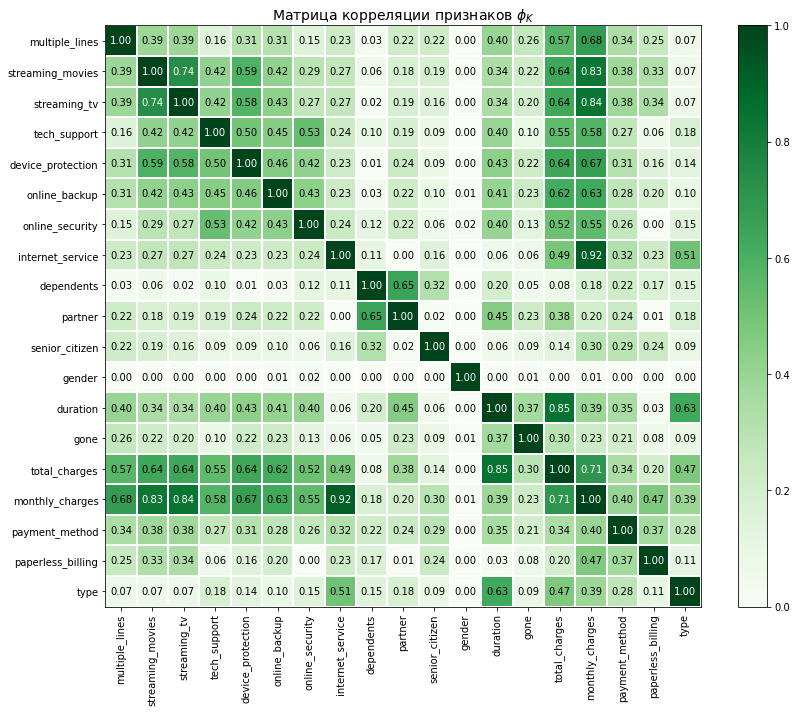

In [24]:
interval_cols = ['monthly_charges', 'total_charges', 'duration']
phik_overview = df.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.round(2).values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Матрица корреляции признаков $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(12, 10))
plt.tight_layout()

Можно заметить, что существует сильная зависимость между расходами за месяц, интернет сервисом и подключенными услугами. Признак пола почти совсем не значим, в том числе и на целевой признак. У целевого признака нет выраженной зависимости с какими-либо признаками - максимальный коэффициент с количеством дней от начала договора - 0.37

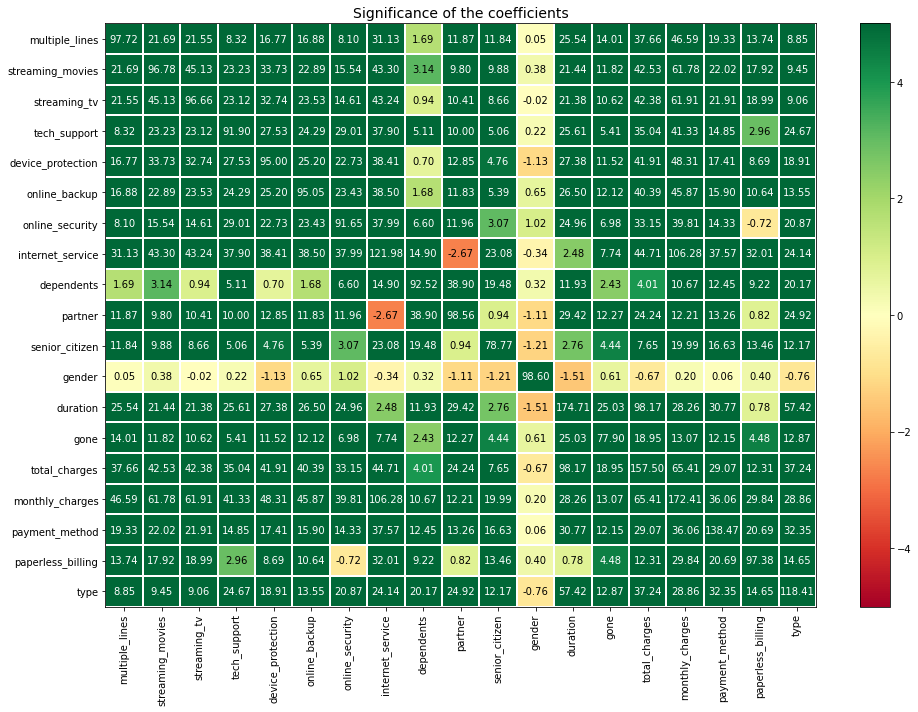

In [25]:
significance_overview = df.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1, figsize=(14, 10))
plt.tight_layout()

Матрица статистической значимости подтверждает выводы о присутствии мультиколлинеарности. Это нужно было бы иметь в виду при построении линейной модели.

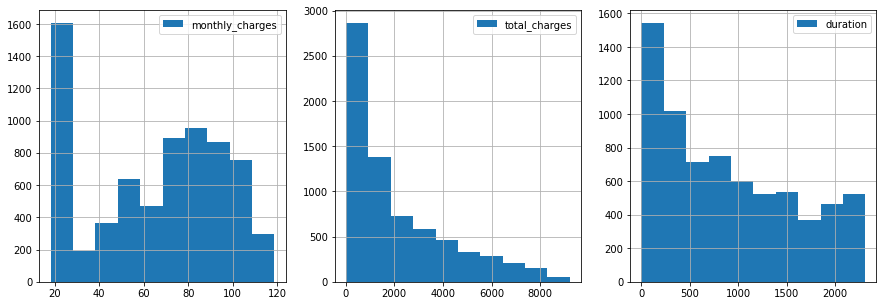

In [26]:
f, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(len(interval_cols)):
    df[interval_cols[i]].hist(figsize=(15, 5), legend=True, ax=axes[i]);

<Figure size 432x288 with 0 Axes>

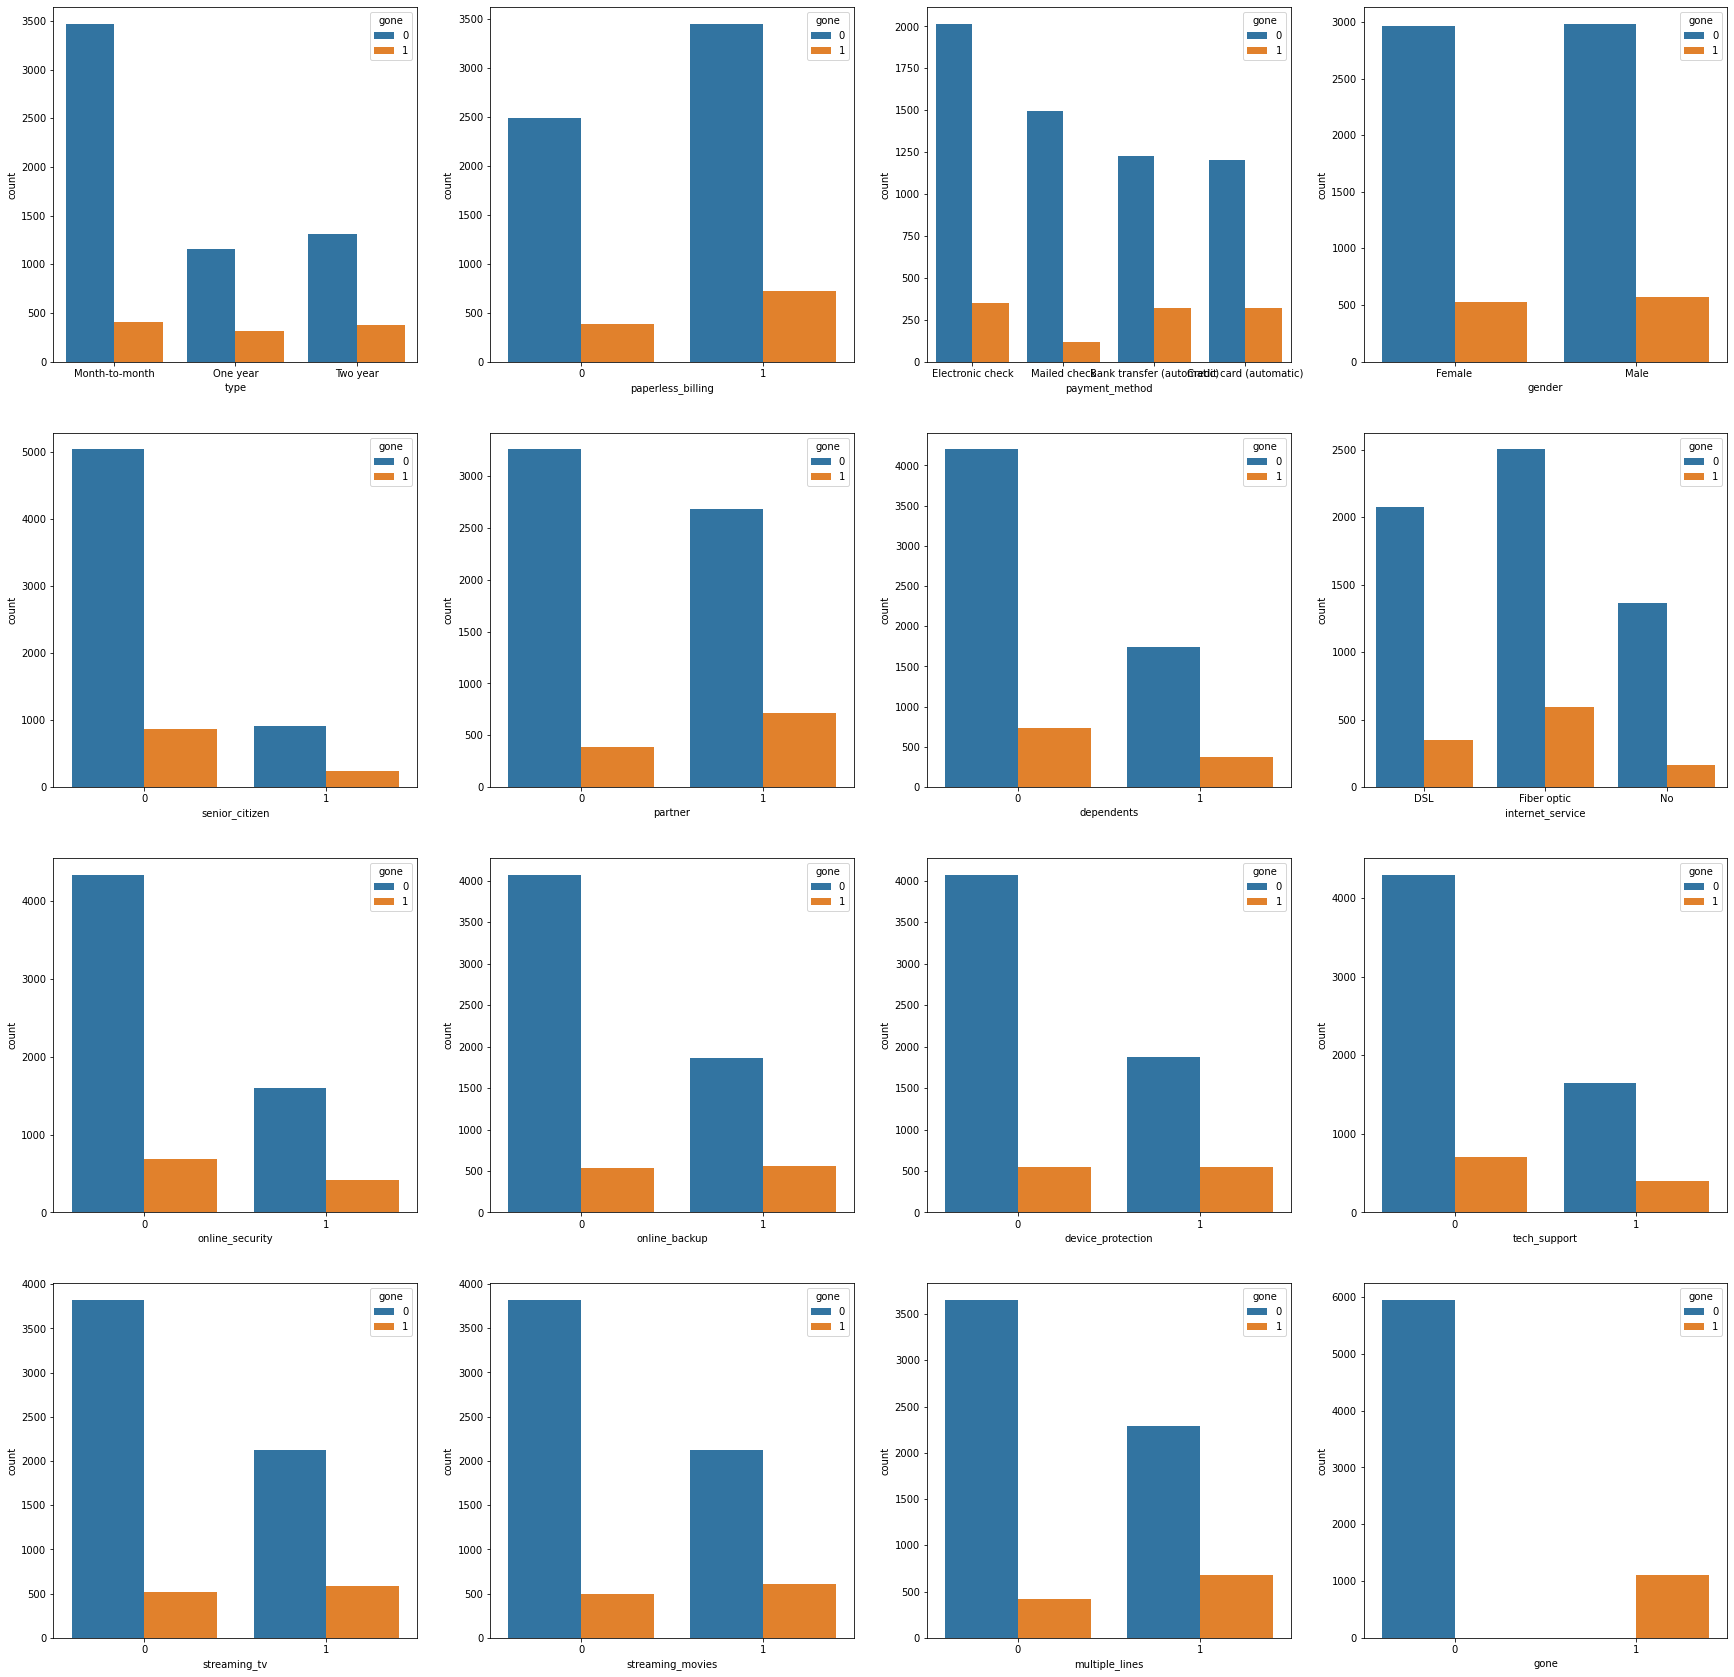

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [27]:
cats =  ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner',
'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection',
'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'gone']

#параметры для функции subplots

fig, axes = plt.subplots(4, 4, figsize=(30, 30))
axe = axes.ravel()

#построение графиков для категориальных переменных

for i, col in enumerate(df[cats].columns):
    plt.figure(i)
    sns.countplot(x=col, data=df, hue='gone', ax=axe[i]);

# Выводы по визуальному анализу  

Можно заметить дисбаланс классов в целевом признаке - в выборке закрыли договор около 15 процентов клиентов.  

Больше половины клиентов договор заключают на месяц. Процент ушедших клиентов в этой категории меньше, чем среди договоров на год и на два. Но нужно принять во внимание, что это возможно потому, что пользуются услугами меньше года - большое количество новых клиентов, по истечению этого срока возможно договор закроют.    

В процентом соотношении ушедших меньше среди тех, кто получают электронный чек и чек на почту относительно двух других категорий.   

Чаще закрывают договор те, у кого есть партнер.  

Больше 20-ти % не подключают интернет. Это не влияет на отток клиентов, как и тип используемого оптического волокна.  

Каждую доп услугу подключает примерно треть клиентов. При этом среди тех кто подключил - ушедших столько же.  

Подключающих многоканальную телефонию на треть меньше, но ушедших среди них больше.   

Четверть клиентов платит минимальную сумму в месяц - до 30 ден. ед.  

Больше полутора тысяч новых клиентов - они пользуются услугами меньше полугода, это сказывается на общих тратах по клиенту.

## Построение модели обучения

In [28]:
#выделение целевого признака

target = df['gone']
features = df.drop('gone', axis=1)

#выделение тренировочной части в соотношении 75% и 25%
fea_train, fea_test, tar_train, tar_test = train_test_split(features, target, test_size=0.25, stratify=target, random_state=220523)

print(fea_train.shape)
print(fea_test.shape)
print(tar_train.shape)
print(tar_test.shape)

(5282, 18)
(1761, 18)
(5282,)
(1761,)


In [29]:
# порядковое кодирование для модели случайного леса

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)

cat_features =  ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner',
'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection',
'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

encoder.fit(fea_train[cat_features])

fea_train_ord = fea_train.copy()
fea_test_ord = fea_test.copy()

fea_train_ord[cat_features] = encoder.transform(fea_train_ord[cat_features])
fea_test_ord[cat_features] = encoder.transform(fea_test_ord[cat_features])

In [30]:
#словарь с параметрами для модели случайного леса

parametrs = { 'max_depth': range (2, 16, 2),
              'n_estimators': range (1, 200, 10) }

In [31]:
model1 = RandomForestClassifier(random_state=220523)

#подбор параметров модели 

grid = GridSearchCV(model1, parametrs, scoring='roc_auc', cv=5, n_jobs=-1, verbose=0)
grid.fit(fea_train_ord, tar_train)
print('Лучшие параметры для RandomForestClassifier', grid.best_params_)
print('Метрика roc_auc', grid.best_score_)

Лучшие параметры для RandomForestClassifier {'max_depth': 8, 'n_estimators': 111}
Метрика roc_auc 0.8330857798282054


Показатель 0.83 меньше требуемого 0.85, обучим другую модель

In [32]:
#словарь с параметрами для модели catboost

parameters = {'depth'         : [4,5,6,7,8,9,10],
                'learning_rate' : [0.01,0.02,0.03,0.04],
                'iterations'    : [1000]
                 }

In [33]:
model2 = CatBoostClassifier(eval_metric='AUC', cat_features=cat_features, random_seed=220523, verbose=0)
pd.DataFrame.iteritems = pd.DataFrame.items

#подбор параметров модели

grid_cbc = GridSearchCV(model2, parameters, scoring='roc_auc', cv=5, n_jobs=-1, verbose=0);
grid_cbc.fit(fea_train, tar_train, verbose=0)
print('Лучшие параметры для CatBoostClassifier', grid_cbc.best_params_)
print('Метрика roc_auc', grid_cbc.best_score_)

Лучшие параметры для CatBoostClassifier {'depth': 5, 'iterations': 1000, 'learning_rate': 0.04}
Метрика roc_auc 0.8942296929602532


Достигли результата, превышающего требуемый на кросс-валидации. Протестируем эту модель на тестовой выборке и исследуем важность признаков.

## Тестирование и анализ модели

In [34]:
model2 = CatBoostClassifier(eval_metric='AUC', 
                            cat_features=cat_features,
                            depth=5, 
                            learning_rate=0.04, 
                            iterations=1000, 
                            random_seed=220523,
                            verbose=0)

model2.fit(fea_train, tar_train, verbose=0)
probabilities = model2.predict_proba(fea_test)
probabilities_one = probabilities[:, 1]

print('Метрика AUC ROC на тестовой выборке лучшей модели', roc_auc_score(tar_test, probabilities_one))

print('Метрика accuracy', model2.score(fea_test, tar_test))

Метрика AUC ROC на тестовой выборке лучшей модели 0.913213018475468
Метрика accuracy 0.9091425326519024


Модель на тестовой выборке показала результаты лучше, следовательно не переобучилась. 

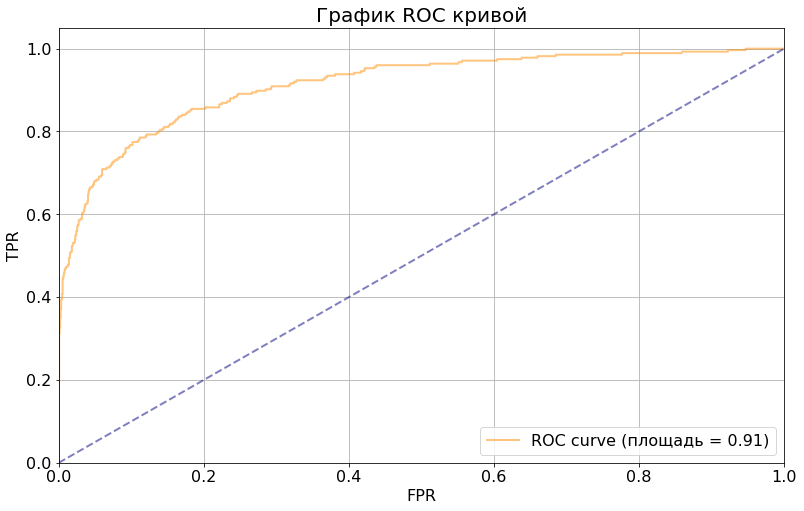

In [35]:
#создание ROC кривой

eval_pool = Pool(fea_test, tar_test, cat_features=cat_features)
curve = get_roc_curve(model2, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)

plt.figure(figsize=(13, 8))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (площадь = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.title('График ROC кривой', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

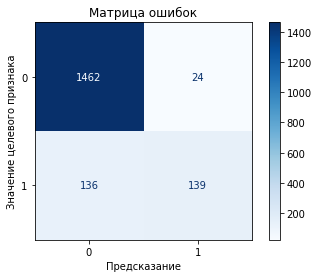

In [36]:
cm = get_confusion_matrix(model2, eval_pool)
color = 'black'
matrix = plot_confusion_matrix(model2, fea_test, tar_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Матрица ошибок', color=color)
plt.xlabel('Предсказание', color=color)
plt.ylabel('Значение целевого признака', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

По матрице можно сделать вывод, что модель почти с 50-ти процентой вероятностью правильно предскажет значение 1

In [37]:
#feature_importance

model2.get_feature_importance(prettified=True)

,Feature Id,Importances
0,duration,49.448939
1,type,9.648008
2,total_charges,8.485033
3,monthly_charges,8.258673
4,payment_method,5.771314
5,partner,3.448153
6,multiple_lines,3.163809
7,internet_service,2.146193
8,device_protection,1.530082
9,online_backup,1.499876


Как заметно по матрице корреляции признаков, наибольшее влияние на целевой оказывает количество дней пользования услугами. 